<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
def load_data(file_dir):
    dataset=pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    
    #remove that row whuch has not any value...
    dataset.drop(index=dataset[dataset['Global_active_power']=='?'].index,inplace=True)
    dataset.to_csv('file1.csv')
    return dataset

In [36]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [37]:
dataset=dataset.astype('float32')

In [38]:
new_data=dataset[['Global_active_power']].resample('1H').sum()

In [39]:
new_data.dropna(inplace=True)
new_data.sort_index(inplace=True)

In [40]:
date_index=new_data.index.to_series()

In [41]:
#new_data['year']=date_index.dt.year
#new_data['month']=date_index.dt.month
#new_data['day_of_week']=date_index.dt.dayofweek
new_data['hour']=date_index.dt.hour

In [42]:
new_data = new_data.reset_index(drop=True)

In [43]:
new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)

In [44]:
new_data.drop(labels=['hour'],axis=1,inplace=True)

In [45]:
mean = new_data.Global_active_power.mean()
std = new_data.Global_active_power.std()
new_data['Global_active_power_mean'] = new_data['Global_active_power']-mean / std

In [46]:
new_data.head()

,Global_active_power,hour_cos,hour_sin,Global_active_power_mean
0,152.024002,-2.588190e-01,-0.965926,150.826233
1,217.932007,-1.836970e-16,-1.000000,216.734238
2,204.013992,2.588190e-01,-0.965926,202.816223
3,196.113998,5.000000e-01,-0.866025,194.916229
4,183.388000,7.071068e-01,-0.707107,182.190231


In [47]:
mean,std

(64.67445373535156, 53.99562072753906)

In [48]:
new_data.drop(labels=['Global_active_power'],axis=1,inplace=True)

In [49]:
WINDOW_SIZE = 100
df_as_np = new_data.to_numpy()
X = []
y = []
for i in range(len(df_as_np)-WINDOW_SIZE):
  row = [ a for a in df_as_np[i:i+WINDOW_SIZE]]
  X.append(row)
  label = df_as_np[i+WINDOW_SIZE][-1]
  y.append(label)
X1,y1 =np.array(X), np.array(y)

In [50]:
X1.shape,y1.shape

((34489, 100, 3), (34489,))

In [51]:
train_input = X1[:23000]
test_input = X1[26000:]
validation_input = X1[23000:26000]
train_target = y1[:23000]
test_target = y1[26000:]
validation_target = y1[23000:26000]

In [52]:
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 100, 3), (8489, 100, 3), (23000,), (8489,))

In [ ]:
train_input

# Models...

**model1..LSTM**

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((100, 3)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


In [54]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=RootMeanSquaredError())

In [55]:
model1.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp1])

Epoch 1/10
719/719 [==============================] - ETA: 0s - loss: 3635.4519 - root_mean_squared_error: 60.2947

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 40s 53ms/step - loss: 3635.4519 - root_mean_squared_error: 60.2947 - val_loss: 1505.9760 - val_root_mean_squared_error: 38.8069
Epoch 2/10
719/719 [==============================] - ETA: 0s - loss: 1647.0337 - root_mean_squared_error: 40.5837

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 39s 55ms/step - loss: 1647.0337 - root_mean_squared_error: 40.5837 - val_loss: 1285.8986 - val_root_mean_squared_error: 35.8594
Epoch 3/10
719/719 [==============================] - ETA: 0s - loss: 1482.9170 - root_mean_squared_error: 38.5087

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 39s 54ms/step - loss: 1482.9170 - root_mean_squared_error: 38.5087 - val_loss: 1226.3296 - val_root_mean_squared_error: 35.0190
Epoch 4/10
718/719 [============================>.] - ETA: 0s - loss: 1414.0068 - root_mean_squared_error: 37.6033

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 38s 53ms/step - loss: 1413.6002 - root_mean_squared_error: 37.5979 - val_loss: 1176.4291 - val_root_mean_squared_error: 34.2991
Epoch 5/10
718/719 [============================>.] - ETA: 0s - loss: 1375.4874 - root_mean_squared_error: 37.0876

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 44s 61ms/step - loss: 1375.2753 - root_mean_squared_error: 37.0847 - val_loss: 1148.2441 - val_root_mean_squared_error: 33.8857
Epoch 6/10
719/719 [==============================] - ETA: 0s - loss: 1349.2854 - root_mean_squared_error: 36.7326

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 40s 55ms/step - loss: 1349.2854 - root_mean_squared_error: 36.7326 - val_loss: 1126.7559 - val_root_mean_squared_error: 33.5672
Epoch 7/10
718/719 [============================>.] - ETA: 0s - loss: 1338.4395 - root_mean_squared_error: 36.5847

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 41s 57ms/step - loss: 1338.3485 - root_mean_squared_error: 36.5834 - val_loss: 1097.0872 - val_root_mean_squared_error: 33.1223
Epoch 8/10
719/719 [==============================] - 35s 49ms/step - loss: 1336.0319 - root_mean_squared_error: 36.5518 - val_loss: 1099.5780 - val_root_mean_squared_error: 33.1599
Epoch 9/10
718/719 [============================>.] - ETA: 0s - loss: 1303.5310 - root_mean_squared_error: 36.1044

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 40s 55ms/step - loss: 1303.7490 - root_mean_squared_error: 36.1075 - val_loss: 1063.5763 - val_root_mean_squared_error: 32.6125
Epoch 10/10
719/719 [==============================] - ETA: 0s - loss: 1277.8318 - root_mean_squared_error: 35.7468

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 41s 57ms/step - loss: 1277.8318 - root_mean_squared_error: 35.7468 - val_loss: 1041.4604 - val_root_mean_squared_error: 32.2717


In [56]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [57]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

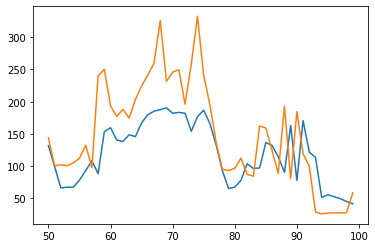

In [58]:
import matplotlib.pyplot as plt
plt.plot(train_results['train_predicted'][50:100])
plt.plot(train_results['train_target'][50:100])

In [71]:
test_predictions = model1.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten(),'error':test_target.flatten()-test_predictions})
test_results

,test_predictions,test_target,error
0,29.093582,18.620228,-10.473354
1,42.704548,43.976227,1.271679
2,84.268806,162.210236,77.941429
3,132.668976,129.436234,-3.232742
4,112.047119,107.468231,-4.578888
...,...,...,...
8484,74.552597,102.356232,27.803635
8485,106.298424,93.210228,-13.088196
8486,102.114197,98.362228,-3.751968
8487,105.670395,68.624229,-37.046165


In [73]:
from sklearn.metrics import mean_absolute_percentage_error

In [74]:
mean_absolute_percentage_error(train_results.train_predicted,train_results.train_target)

0.507318032888245

In [76]:
mean_absolute_percentage_error(test_results.test_predictions,test_results.test_target)

0.63881485777805

**MODEL2..Conv1D**

In [ ]:
model2 = Sequential()
model2.add(InputLayer((100, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp2])

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [ ]:
test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_absolute_percentage_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_absolute_percentage_error(train_results.train_predicted,train_results.train_target)

**Model3...GRU**

In [ ]:
model3 = Sequential()
model3.add(InputLayer((100, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)